Imports

In [176]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import requests
import time
import os
import copy
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from PIL import Image
from collections import Counter, defaultdict
# from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms


Display the matplotlib images inline, and set to interactive mode

In [148]:
%matplotlib inline

plt.ion()

First, load the dataset and print some of the images just to test the loader correctly.

In [168]:
img_32x32_size_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  # ensure that images are 32x32
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # normalize to [-1,1]
])

gtsrb_path = "/content"

train_percent = 0.8 # 80% training set -> 20% validation set

train_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=img_32x32_size_transform)

train_size = int(train_percent*len(train_set))

val_size = int(len(train_set) - train_size)

train_set, val_set = random_split(train_set,[train_size, val_size])

test_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=img_32x32_size_transform)

test_set_size = int(len(test_set)*0.9)

test_vis_size= int(len(test_set) - test_set_size)

test_set, test_vis_set = random_split(test_set,[test_set_size,test_vis_size])

training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

Setting the hyper parameters

In [150]:
bs = 64  # batch size
lr = 0.01  # learning rate
epochs = 20  # number of epochs
momentum = 0.9 # for optimizer
step_size = 3 # step size for learning rate scheduler
gamma = 0.1 # gamma for learning rate scheduler

Initializing the classes label names

In [151]:
class_names = [
    "Speed limit (20km/h)",         # 0
    "Speed limit (30km/h)",         # 1
    "Speed limit (50km/h)",         # 2
    "Speed limit (60km/h)",         # 3
    "Speed limit (70km/h)",         # 4
    "Speed limit (80km/h)",         # 5
    "End of speed limit (80km/h)",  # 6
    "Speed limit (100km/h)",        # 7
    "Speed limit (120km/h)",        # 8
    "No passing",                   # 9
    "No passing for vehicles over 3.5 metric tons",  # 10
    "Right-of-way at the next intersection",         # 11
    "Priority road",                # 12
    "Yield",                        # 13
    "Stop",                         # 14
    "No vehicles",                  # 15
    "Vehicles over 3.5 metric tons prohibited",      # 16
    "No entry",                     # 17
    "General caution",              # 18
    "Dangerous curve to the left",  # 19
    "Dangerous curve to the right", # 20
    "Double curve",                 # 21
    "Bumpy road",                   # 22
    "Slippery road",                # 23
    "Road narrows on the right",    # 24
    "Road work",                    # 25
    "Traffic signals",              # 26
    "Pedestrians",                  # 27
    "Children crossing",            # 28
    "Bicycles crossing",            # 29
    "Beware of ice/snow",           # 30
    "Wild animals crossing",        # 31
    "End of all speed and passing limits",  # 32
    "Turn right ahead",             # 33
    "Turn left ahead",              # 34
    "Ahead only",                   # 35
    "Go straight or right",         # 36
    "Go straight or left",          # 37
    "Keep right",                   # 38
    "Keep left",                    # 39
    "Roundabout mandatory",         # 40
    "End of no passing",            # 41
    "End of no passing by vehicles over 3.5 metric tons"  # 42
]

Visualize dataset

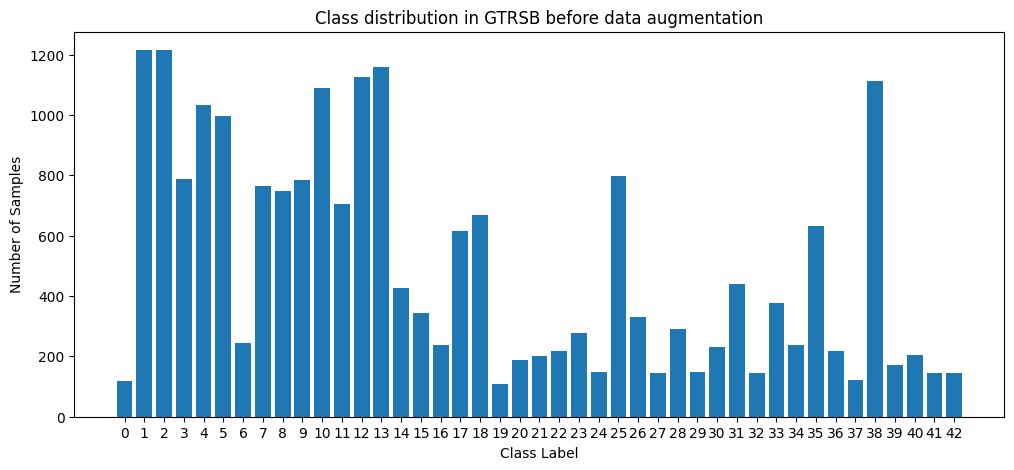

In [169]:

def visualize_dataset_distribution(data_loader, title_extending):
  # Initialize a counter to keep track of class labels
  class_counts = Counter()

  # Iterate through the subset
  for images, labels in data_loader:
      class_counts.update(labels.numpy())  # Update the counter with the labels of this batch

  # Convert the counter to a sorted list
  sorted_class_counts = sorted(class_counts.items())

  # Unzip the sorted counts
  classes, counts = zip(*sorted_class_counts)

  # Plot the class distribution
  plt.figure(figsize=(12, 5))
  plt.bar(classes, counts)
  plt.xlabel('Class Label')
  plt.ylabel('Number of Samples')
  plt.title(f'Class distribution in GTRSB {title_extending}')
  plt.xticks(classes)  # Show class labels on x-axis
  plt.show()

train_loader_vis = DataLoader(train_set, batch_size=64, shuffle=False)
visualize_dataset_distribution(train_loader_vis, "before data augmentation")

In [170]:
few_img_classes = [0, 6, 16, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 32, 34, 36, 37, 39, 40, 41, 42]

filtering data form original dataset

In [171]:
def get_filtererd_dataset(dataset, filter_classes):
  indices = [i for i, (_, label) in enumerate(dataset) if label in filter_classes] # gets indexes of images from classes specified into a list

  return Subset(dataset, indices) # making subset with image indexes from train set

filtered_dataset = get_filtererd_dataset(train_set, few_img_classes)

Transformations on images

In [172]:
transform_1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.RandomRotation(degrees=(-15, 15)),              # Tilt signs
    torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)  # Color variations
])

transform_2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  # Shift signs
    torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5)  # Perspective warp
])

Defining new Dataset with custom augmentation

In [173]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        new_image = self.transform(image)
        return new_image, label

augmented_dataset_1 = AugmentedDataset(filtered_dataset, transform_1)
augmented_dataset_2 = AugmentedDataset(filtered_dataset, transform_2)

Creating extended dataset

In [174]:
train_set = ConcatDataset([train_set, augmented_dataset_1, augmented_dataset_2])

Visualize it again, now the extended dataset

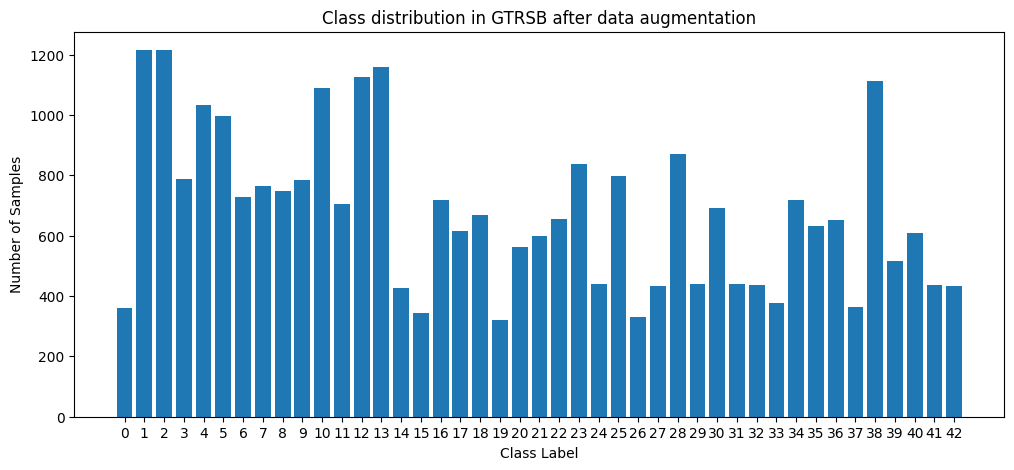

In [175]:
train_loader_vis = DataLoader(train_set, batch_size=64, shuffle=False)
visualize_dataset_distribution(train_loader_vis, "after data augmentation")

Code to get first 300 images of every class

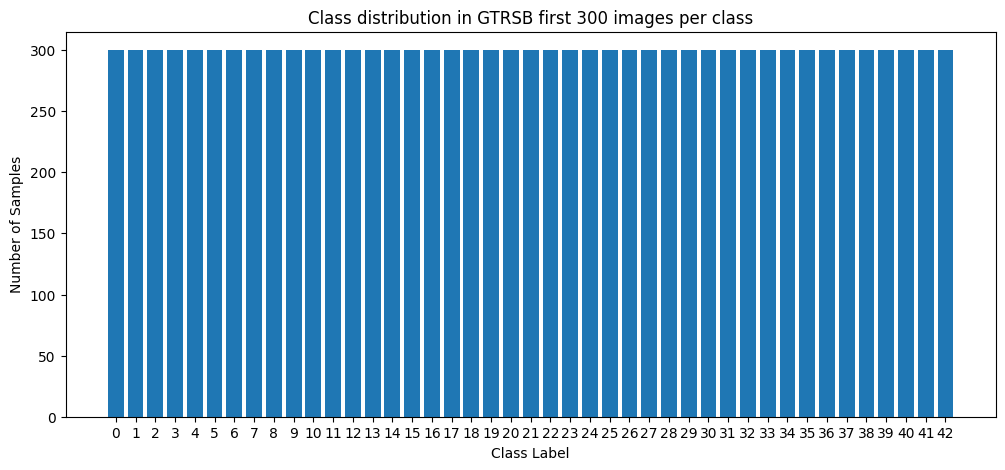

In [177]:
def get_first_n_images(dataset, num_of_images_per_class):
  class_indices = defaultdict(list)

  for idx, (_, label) in enumerate(dataset):
      class_indices[label].append(idx)

  selected_indices = []

  for label, indices in class_indices.items():
      selected_indices.extend(indices[:num_of_images_per_class])

  return Subset(dataset, selected_indices)

first_n_dataset = get_first_n_images(train_set, 300)
first_n_loader = DataLoader(first_n_dataset, batch_size=64, shuffle=False)
visualize_dataset_distribution(first_n_loader, "first 300 images per class")

Creating the loader for the data

In [166]:
train_data_loader = DataLoader(train_set,batch_size=bs, shuffle=True) # schuffle only in train set
val_data_loader = DataLoader(val_set,batch_size=bs, shuffle=False)
test_data_loader = DataLoader(test_set,batch_size=bs, shuffle=False)
test_vis_data_loader = DataLoader(test_vis_set, batch_size=bs, shuffle=False)

data_loaders = {
    "train": train_data_loader,
    "val" : val_data_loader,
    "test": test_data_loader,
    "vis": test_vis_data_loader
}

data_set_sizes = {
    "train": len(train_data_loader),
    "val": len(val_data_loader),
    "test": len(test_data_loader),
    "vis": len(test_vis_data_loader)
}

Optionally print some images out of the dataset (since batch size is 64, we get 64 images out of the dataset)

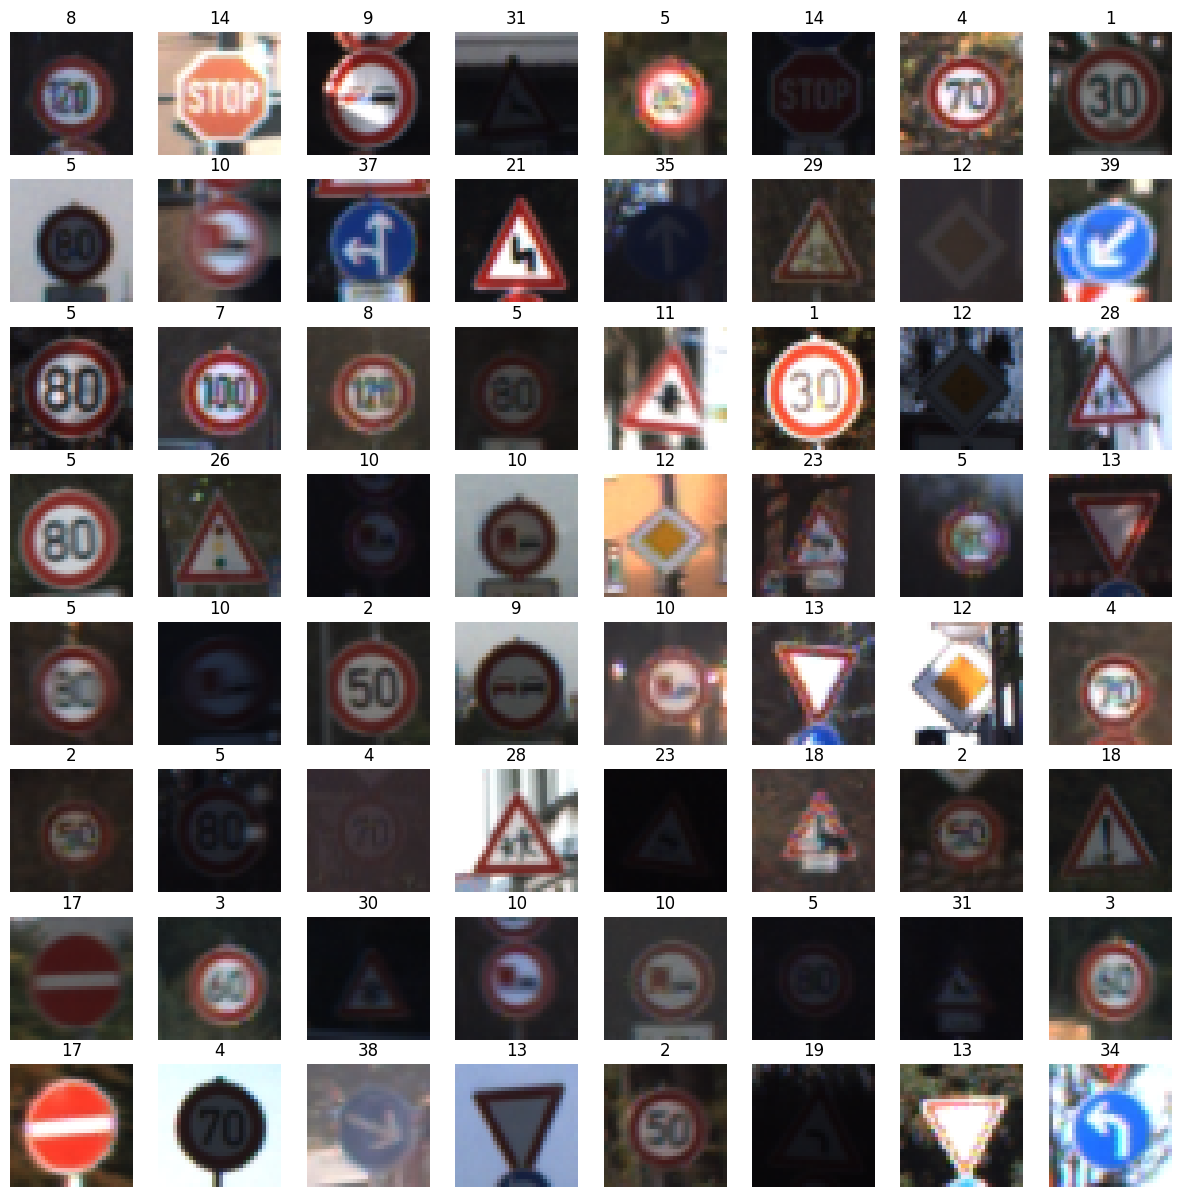

In [131]:
def imshow(images, labels):
  plt.figure(figsize=(15,15))
  for i in range(len(images)):
    plt.subplot(8,8,i+1)
    plt.imshow(images[i].permute(1,2,0)) # (3, 32, 32) -> (32, 32, 3)
    plt.title(labels[i].item())
    plt.axis("off")
  plt.show()

images, labels = next(iter(test_vis_data_loader)) # get a pack (64) of images

imshow(images, labels)

Setting up the model

In [132]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)

in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
    nn.Linear(in_feature_number, 512),
    # nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
    nn.ReLU(),
    nn.Linear(512, 43)
)

# print(model)
print('\nModel is built')


Model is built


Using the GPU if available

In [133]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Visualizing the loss and accuracy for validation and training

In [134]:
def visualize_loss_and_acc(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10,10))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label="Training accuracy")
    plt.plot(val_acc, label="Validation accuracy")
    plt.title("Training and Validation accuracy")

    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Training and Validation loss")

    plt.legend()

    plt.show()

Functions to show metrics for gradients and weights in the model.

In [135]:
## Gradients

def plot_gradient_norms(model):
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
    if grad_norms != []:
        plt.plot(grad_norms)
        plt.xlabel("Layer")
        plt.ylabel("Gradient Norm")
        plt.title("Gradient Norms Across Layers")
        plt.show()

def plot_gradient_histogram(model):
    all_grads = []
    for param in model.parameters():
        if param.grad is not None:
            all_grads.append(param.grad.view(-1))
    if all_grads != []:
      all_grads = torch.cat(all_grads).cpu().numpy()

      plt.hist(all_grads, bins=100, range=(-1, 1))  # Adjust range if necessary
      plt.xlabel("Gradient Value")
      plt.ylabel("Frequency")
      plt.title("Gradient Histogram")
      plt.show()

def plot_gradient_heatmap(model):
    for name, param in model.named_parameters():
        if param.grad is not None and param.grad.ndimension() == 2:
            grad = param.grad.cpu().numpy()
            plt.figure(figsize=(10, 1))
            sns.heatmap(grad, cmap="coolwarm", cbar=True)
            plt.title(f"Gradient heatmap for {name}")
            plt.show()

## Weights

def plot_weight_norms(model):
    weight_norms = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_norms.append(param.data.norm().item())
    plt.plot(weight_norms, marker="o")
    plt.xlabel("Layer")
    plt.ylabel("Weight Norm")
    plt.title("Weight Norms Across Layers")
    plt.show()

def plot_weight_histogram(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.cpu().numpy()
            plt.figure(figsize=(6, 4))
            plt.hist(weights.ravel(), bins=100)
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")
            plt.title(f"Weight Histogram for {name}")
            plt.show()

def plot_weight_heatmap(model):
    for name, param in model.named_parameters():
        if 'weight' in name and param.data.ndimension() == 2:  # Fully connected layers
            weights = param.data.cpu().numpy()
            plt.figure(figsize=(10, 5))
            sns.heatmap(weights, cmap="coolwarm", cbar=True)
            plt.title(f"Weight Heatmap for {name}")
            plt.show()

def visualize_conv_filters(model):
    for name, param in model.named_parameters():
        if 'conv' in name and 'weight' in name:
            weights = param.data.cpu()
            num_filters = weights.shape[0]  # Number of filters
            fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(12, 4))
            for i in range(min(num_filters, 8)):  # Show up to 8 filters
                filter = weights[i].squeeze()
                axes[i].imshow(filter, cmap="gray")
                axes[i].set_title(f"Filter {i}")
                axes[i].axis("off")
            plt.suptitle(f"Filters for {name}")
            plt.show()

Function to call visualizations

In [136]:
def visualize_after_training_metrics(model, train_acc, val_acc, train_loss, val_loss):
  visualize_loss_and_acc(train_acc, val_acc, train_loss, val_loss)
  plot_weight_norms(model)
  plot_weight_histogram(model)
  plot_weight_heatmap(model)

def visualize_gradients(model):
  plot_gradient_norms(model)
  plot_gradient_histogram(model)
  plot_gradient_heatmap(model)


Setting up the training method

In [137]:
# # Generic function to train a model
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     model = model.to(device)

#     # Copy weights
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     train_acc = []
#     val_acc = []
#     train_loss = []
#     val_loss = []

#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print('-' * 20)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in data_loaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history only if in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 curr_loss = loss.item() * inputs.size(0)
#                 curr_corrects = torch.sum(preds == labels.data)

#                 running_loss += curr_loss
#                 running_corrects += curr_corrects

#             epoch_loss = running_loss / data_set_sizes[phase]
#             epoch_acc = running_corrects.double() / data_set_sizes[phase]

#             visualize_gradients(model)

#             if phase == 'train':
#                 scheduler.step()

#             if phase == 'train':
#                 train_acc += [float(epoch_acc)]
#                 train_loss += [float(epoch_loss)]
#             else:
#                 val_acc += [float(epoch_acc)]
#                 val_loss += [float(epoch_loss)]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)

#     return model, train_acc, val_acc, train_loss, val_loss

New training method

In [138]:
def train_model(model,
                criterion,
                optimizer,
                lr_scheduler,
                train_set,
                val_set,
                num_epochs=25,
                batch_size=2,
                batches_per_epoch=None,
                show = False
                ):
    #We keep track of the time it takes to run this function
    since = time.time()

    #We utilise the GPU if its avaliable
    model = model.to(device)

    # We initialise the value we want to keep after execution
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Lists that contain the values after each epoch
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    train_acc_hist = []
    val_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []

    plot_time_train = []
    plot_time_valid = []

    #We encapsulate our images and labels in a Dataloader

    # Set up data loaders
    if batches_per_epoch == None:
      # Use all images
      train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=bs,
                                            shuffle=True, num_workers=2)
      val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=bs,
                                          shuffle=False, num_workers=2)
      batches_per_epoch = len(train_data_loader)
    else:
      # Only use a subset of the data
      subset_indices = list(range(batches_per_epoch*bs))
      train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices, ), num_workers=2)

      # Use one fourth for validation
      subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
      val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)


    data_loader = { "train" : train_data_loader, "val" : val_data_loader }
    data_loader_len = { "train" : len(train_data_loader), "val" : len(val_data_loader) }
    print("DataLoaders set up succesfully")

    # Total number of batches
    t=1
    T = batches_per_epoch * epochs

    #We repeat this proccess for the number of epochs fixed
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} Batches per epoch: {batches_per_epoch} Total number of batches: {T}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                t = 1
            else:
                model.eval()   # Set model to evaluate mode
                t = 1

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                optimizer.param_groups[0]['lr'] = lr_scheduler(t,T,lr=optimizer.param_groups[0]['lr'])

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

                if phase == 'train':
                  train_acc_hist.append(float(curr_corrects))
                  train_loss_hist.append(float(curr_loss))
                  # print('t',t,'lr',optimizer.param_groups[0]['lr'],'train loss',curr_loss)
                  plot_time_train.append(t)
                  t += 1
                else:
                  val_acc_hist.append(float(curr_corrects))
                  val_loss_hist.append(float(curr_loss))
                  plot_time_valid.append(t)
                  t += 1

            epoch_loss = running_loss / data_loader_len[phase]
            epoch_acc = running_corrects.double() / data_loader_len[phase]

            if phase == 'train':
                train_acc.append(float(epoch_acc))
                train_loss.append(float(epoch_loss))
            else:
                val_acc.append(float(epoch_acc))
                val_loss.append(float(epoch_loss))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if show == True :
              plot_gradient_histogram(model)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
#
    #visualize_metrics(train_acc, val_acc, train_loss, val_loss)
#
    ## load best model weights
    model.load_state_dict(best_model_wts)

    if show == True :
      plt.figure()
      lines = []
      labels = []
      l, = plt.plot(plot_time_train,train_loss_hist)
      lines.append(l)
      labels.append('Training')
      plt.title('Loss')
      plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
      plt.show()
    #We return the train_loss
    return model, train_acc, val_acc, train_loss, val_loss

Setting up the visualizing method

In [139]:
def evaluate_model(model):
    was_training = model.training
    model.eval()

    model = model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    return conf_matrix_normalized

Method to show some predictions on unseen images

In [140]:
def show_predictions(model, num_of_images=6):
    was_training = model.training
    model.eval()
    model = model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['vis']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1, 2, 0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Preparing the model for feature extraction (original model's weights are freezed, classfier layer is trainable), setting the loss function, optimizer and learning rate scheduler

In [142]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
loss_function = nn.CrossEntropyLoss()

lr_list = np.logspace(-2.2040816326530610,-1.9,333) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
# print(lr_list)
batches_per_epoch = len(lr_list)
# epochs = 1
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


def CLR(t,T,lr):
  return lr_list[t-1]


# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Train the model

In [143]:
model, train_acc, val_acc, train_loss, val_loss = train_model(model, loss_function, optimizerSGD, CLR, train_set, val_set, num_epochs=epochs,batches_per_epoch=None, show=False)

DataLoaders set up succesfully
Epoch 1/20 Batches per epoch: 186 Total number of batches: 3720
--------------------


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py", line 350, in __getitem__
    return self.datasets[dataset_idx][sample_idx]
  File "<ipython-input-127-e68e171c2d9b>", line 11, in __getitem__
    new_image = self.transform(image)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


Call the visualizations

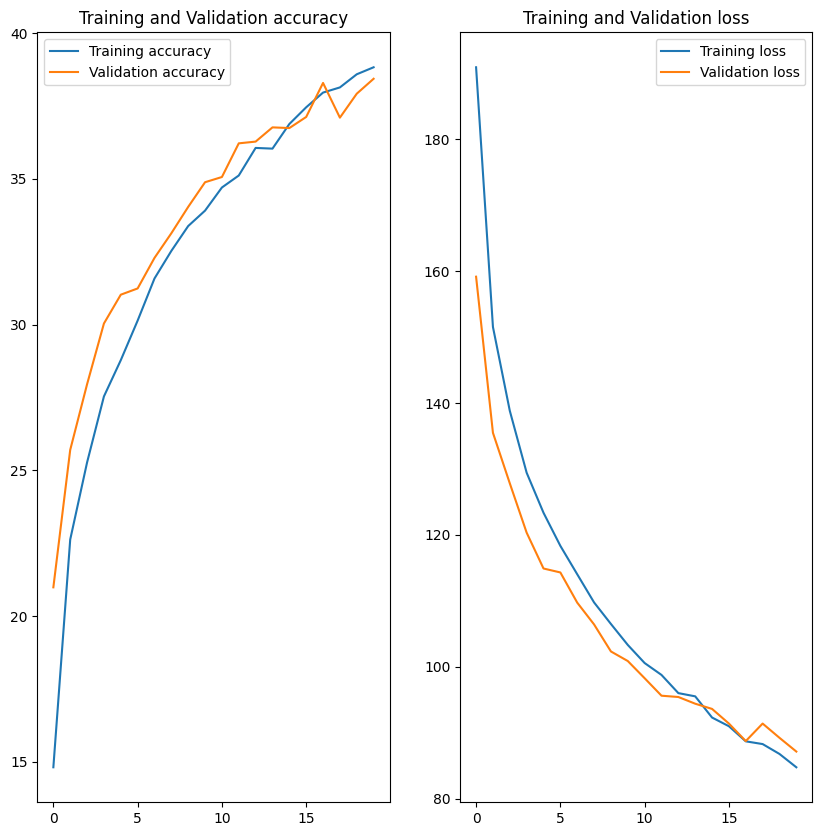

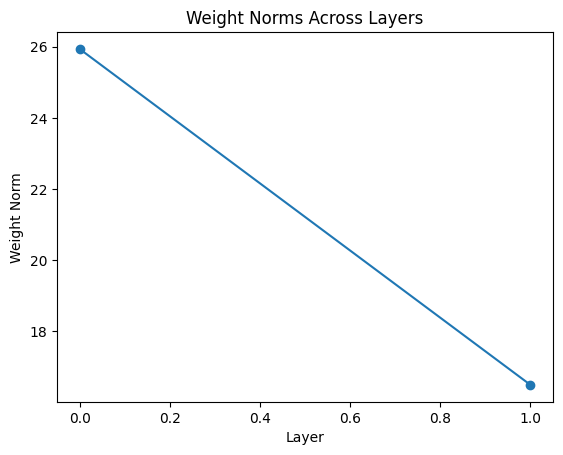

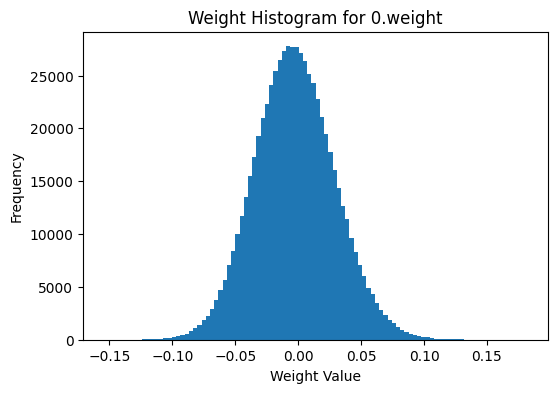

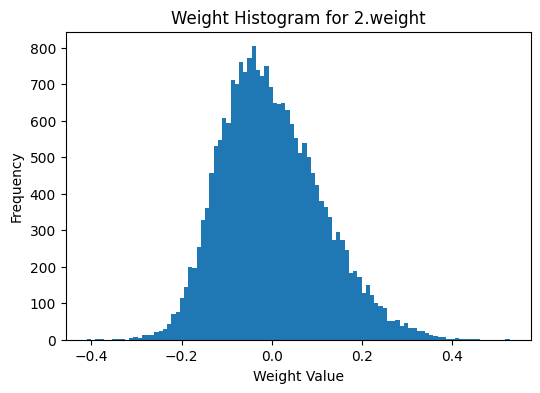

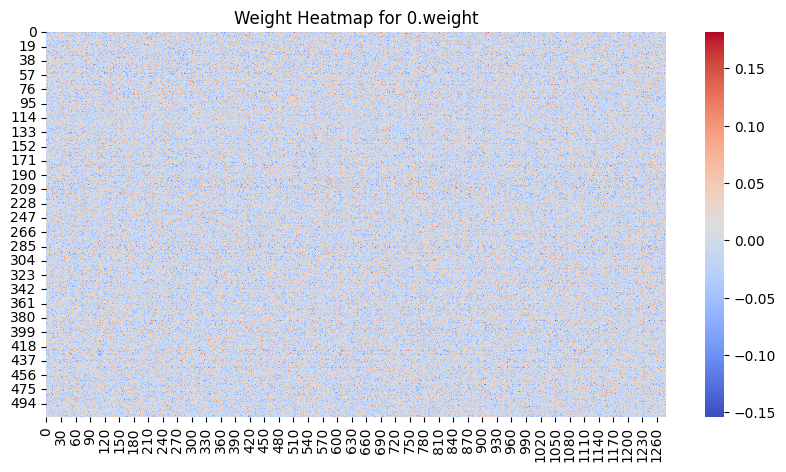

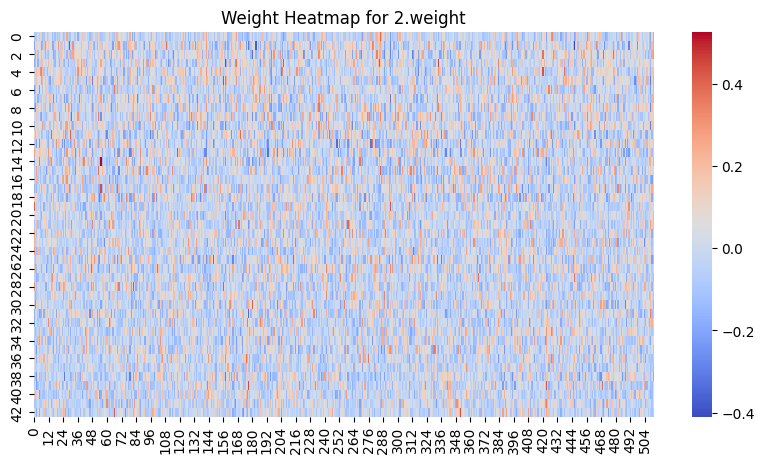

In [83]:
visualize_after_training_metrics(model.classifier, train_acc, val_acc, train_loss, val_loss)

Evaluate the model form the test data loader

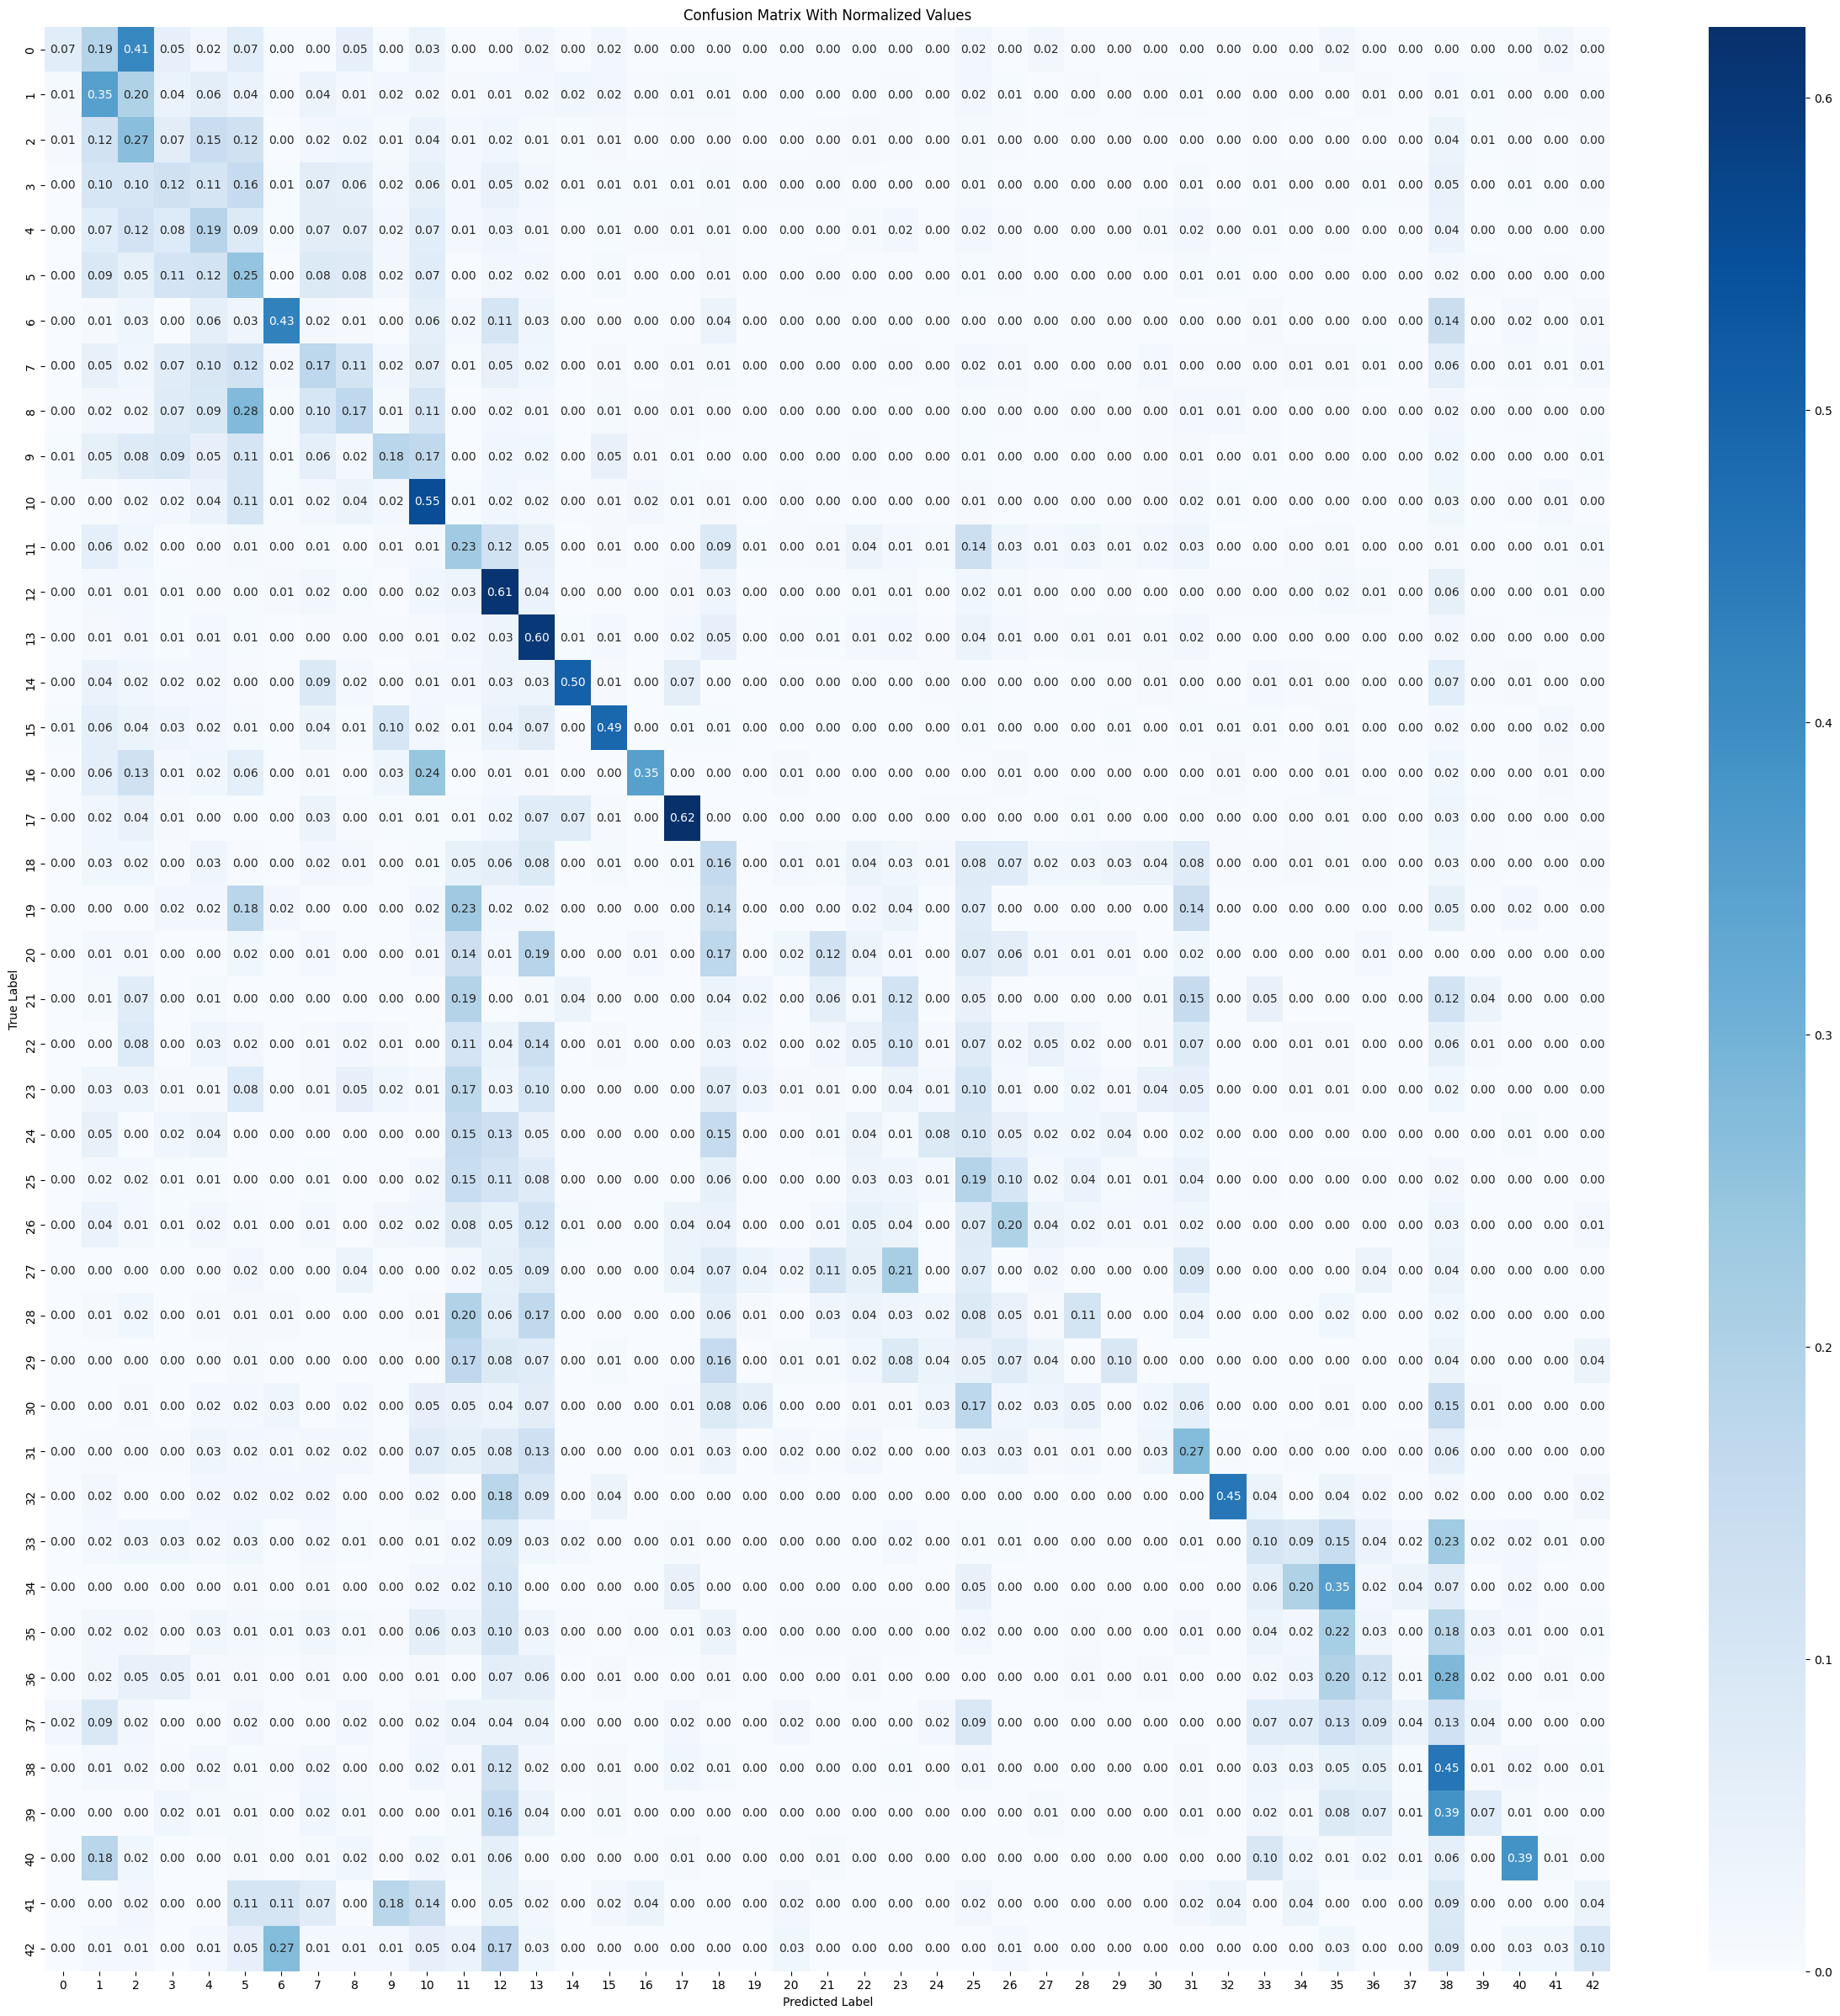

In [84]:
conf_matrix = evaluate_model(model)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix With Normalized Values")
plt.show()

Show some predictions with the model

In [85]:
show_predictions(model) # 6 images are shown by default

Error in callback <function flush_figures at 0x7f85f993d1b0> (for post_execute):


KeyboardInterrupt: 

Fine tuning model

In [86]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Train the model again

In [87]:
model,train_acc2, val_acc2, train_loss2, val_loss2 = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

TypeError: train_model() missing 2 required positional arguments: 'train_set' and 'val_set'

Visualize results

In [ ]:
visualize_after_training_metrics(model.classifier, train_acc2, val_acc2, train_loss2, val_loss2)

Show some predictions with the fine tuned model again

In [ ]:
conf_matrix = evaluate_model(model)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()